#Following McKinney's Pycon presentation:<br>"Data analysis in Python with Pandas"

###Exploring US births and baby names datasets (1880-2009).


### Learning about...
   <ul>
   <li>reading from a csv file into a DataFrame
   <li>exploring the schema
   <li>indices, MultiIndex
   <li>set indices for faster access
   <li>groupby()
   <li>rank()
   <li>dataframe joins
   <li>apply() funcs on cols
   <li>plotting
   </ul>
###https://www.youtube.com/watch?v=w26x-z-BdWQ


In [36]:

%matplotlib inline

import matplotlib.pyplot as plt
from pandas import *

set_option('max_columns', 20)
set_option('max_rows', 10)

names = read_csv("baby-names2.csv")

## Explore schema a little...

In [37]:
names.head()

,year,name,prop,sex,soundex
0,1880,John,0.081541,boy,J500
1,1880,William,0.080511,boy,W450
2,1880,James,0.050057,boy,J520
3,1880,Charles,0.045167,boy,C642
4,1880,George,0.043292,boy,G620


In [38]:
names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258000 entries, 0 to 257999
Data columns (total 5 columns):
year       258000 non-null int64
name       258000 non-null object
prop       258000 non-null float64
sex        258000 non-null object
soundex    258000 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 11.8+ MB


In [39]:
names[names.year == 1880]

,year,name,prop,sex,soundex
0,1880,John,0.081541,boy,J500
1,1880,William,0.080511,boy,W450
2,1880,James,0.050057,boy,J520
3,1880,Charles,0.045167,boy,C642
4,1880,George,0.043292,boy,G620
...,...,...,...,...,...
129995,1880,Emaline,0.000041,girl,E545
129996,1880,Ester,0.000041,girl,E236
129997,1880,Eulah,0.000041,girl,E400
129998,1880,Eulalie,0.000041,girl,E440


## Create sub-DataFrames for boys and girls (so very 1880's partitions).


In [40]:

boys = names[names.sex == "boy"]
girls = names[names.sex == "girl"]

boys.shape, girls.shape



((129000, 5), (129000, 5))

## Start using groupby...

In [41]:
bg = boys.groupby('year')
bg.size()


year
1880    1000
1881    1000
1882    1000
1883    1000
1884    1000
        ... 
2004    1000
2005    1000
2006    1000
2007    1000
2008    1000
dtype: int64

## "prop" column: proportion of babies with a specific name, on a specific year

In [42]:
# easy to operate other cols
boys.groupby("name")["prop"].mean()
boys.groupby("name")["prop"].mean().order()



name
Kennard     0.000027
Danniel     0.000027
Deryl       0.000028
Grayling    0.000028
Michial     0.000028
              ...   
Charles     0.019521
Robert      0.029625
William     0.034182
James       0.035465
John        0.041082
Name: prop, dtype: float64

In [43]:
# describe(), a Series op, very useful, concise way to look at summary stats, for each group!

result = boys.groupby("name")["prop"].describe()
set_option("display.max_rows", 50)
result[:20]


name        
Aaden  count      1.000000
       mean       0.000442
       std             NaN
       min        0.000442
       25%        0.000442
       50%        0.000442
       75%        0.000442
       max        0.000442
Aarav  count      1.000000
       mean       0.000101
       std             NaN
       min        0.000101
       25%        0.000101
       50%        0.000101
       75%        0.000101
       max        0.000101
Aaron  count    129.000000
       mean       0.002266
       std        0.002545
       min        0.000351
dtype: float64

## Hierarchical indexing.

In [44]:
hgrp1 = names.groupby(["year", "sex"])

set_option("display.max_rows", 20)

hgrp1.size()



year  sex 
1880  boy     1000
      girl    1000
1881  boy     1000
      girl    1000
1882  boy     1000
      girl    1000
1883  boy     1000
      girl    1000
1884  boy     1000
      girl    1000
              ... 
2004  boy     1000
      girl    1000
2005  boy     1000
      girl    1000
2006  boy     1000
      girl    1000
2007  boy     1000
      girl    1000
2008  boy     1000
      girl    1000
dtype: int64

## Most popular boy name in 2000.


In [45]:
boys[boys.year == 2000].sort_index(by="prop", ascending=False)[:10]

,year,name,prop,sex,soundex
120000,2000,Jacob,0.016514,boy,J210
120001,2000,Michael,0.015346,boy,M240
120002,2000,Matthew,0.013695,boy,M300
120003,2000,Joshua,0.013194,boy,J200
120004,2000,Christopher,0.011990,boy,C623
120005,2000,Nicholas,0.011815,boy,N242
120006,2000,Andrew,0.011324,boy,A536
120007,2000,Joseph,0.010930,boy,J210
120008,2000,Daniel,0.010681,boy,D540
120009,2000,Tyler,0.010305,boy,T460


In [46]:
# jds note: df.sort_index() == df.sort()

boys[boys.year == 2000].sort("prop", ascending=False)[:10]

,year,name,prop,sex,soundex
120000,2000,Jacob,0.016514,boy,J210
120001,2000,Michael,0.015346,boy,M240
120002,2000,Matthew,0.013695,boy,M300
120003,2000,Joshua,0.013194,boy,J200
120004,2000,Christopher,0.011990,boy,C623
120005,2000,Nicholas,0.011815,boy,N242
120006,2000,Andrew,0.011324,boy,A536
120007,2000,Joseph,0.010930,boy,J210
120008,2000,Daniel,0.010681,boy,D540
120009,2000,Tyler,0.010305,boy,T460


In [47]:
# idx of row w/ max prop
max_ix = boys[boys.year == 2000].prop.idxmax()
print(max_ix)
boys.ix[max_ix]



120000


year           2000
name          Jacob
prop       0.016514
sex             boy
soundex        J210
Name: 120000, dtype: object

In [48]:
# let's make the max extraction more generic...

def get_max_record(group):
    return group.ix[group.prop.idxmax()]

grp_2k = boys[boys.year == 2000]
get_max_record(grp_2k)


year           2000
name          Jacob
prop       0.016514
sex             boy
soundex        J210
Name: 120000, dtype: object

In [49]:
# year which had the highest prop name (1880, 80% of boys were named John)
get_max_record(boys)


year           1880
name           John
prop       0.081541
sex             boy
soundex        J500
Name: 0, dtype: object

In [50]:
# and, each year...
for yr in set(boys.year):
    get_max_record(boys[boys.year == yr])
    


In [51]:
# or, much simpler...
set_option("display.max_rows", 20)
result = boys.groupby("year").apply(get_max_record)

result

,year,name,prop,sex,soundex
year,,,,,
1880,1880,John,0.081541,boy,J500
1881,1881,John,0.080975,boy,J500
1882,1882,John,0.078314,boy,J500
1883,1883,John,0.079066,boy,J500
1884,1884,John,0.076476,boy,J500
1885,1885,John,0.075517,boy,J500
1886,1886,John,0.075820,boy,J500
1887,1887,John,0.074181,boy,J500
1888,1888,John,0.071186,boy,J500


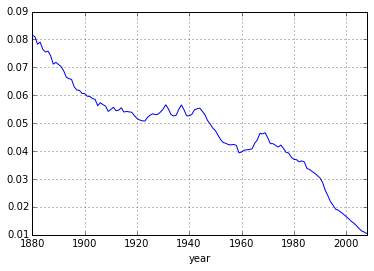

In [52]:
set_option("display.max_rows", 12)

# notice how the proportionality of most popular names goes down as time goes by
result.prop
result.prop.plot()




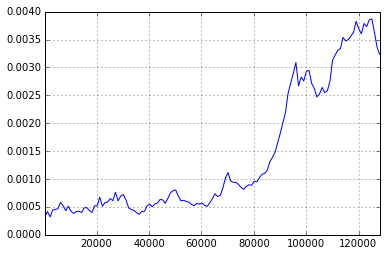

In [53]:
# back to global boys dataset; remember, each year a name appears only once
# (with its prop for that year)

boys[:10]

# how has Juan done...?
boys[boys.name == 'Juan'].prop
boys[boys.name == 'Juan'].prop.plot()


## Learn about set_index()

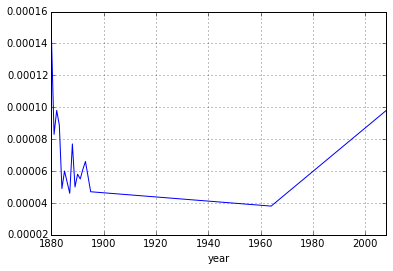

In [54]:
# but the above can be slow w/ large datasets
# better, faster way -> take cols of interest and make them an index

ny_indexed_df = boys.set_index(["name", "year"])
#yn_indexed_df = boys.set_index(["year", "name"])

# now you can use them as indices...
ny_indexed_df.ix["Juan", 2002]
ny_indexed_df.ix["Cassius"].prop.plot()



## Perform aggregate ops on columns...

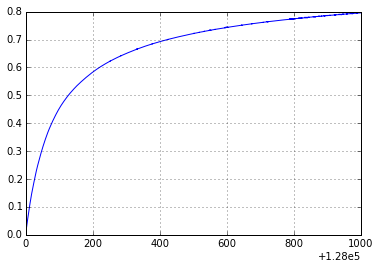

In [55]:
set_option('display.max_rows', 10)

boys[boys.year == 2008]

# use prop as the index to sort (descending order)
df = boys[boys.year == 2008].sort_index(by="prop", ascending=False)

# perform ops on cols
# (in 2008, the top 1000 names represent the 79% of all boys' names)
df.prop.cumsum()
df.prop.cumsum().plot()


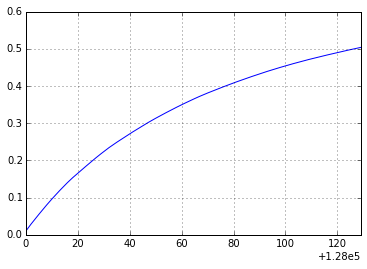

In [56]:
# at what point does the cumsum reach 50%?
df.prop.cumsum().searchsorted(0.5)  # 127
df.prop.cumsum()[:130].plot()

In [57]:
# so, in 2008, it took 127 names to reach 50% of the names
# how about in 1880... -> 15! (much more consolidated) (Hi John, I'm John)
boys[boys.year == 1880].sort_index(by="prop", ascending=False).prop.cumsum().searchsorted(0.5)

array([15])

## Plot: for each year, how many names represented 50% of all names?
### (hint: as time's gone by, we've become more... special and unique)

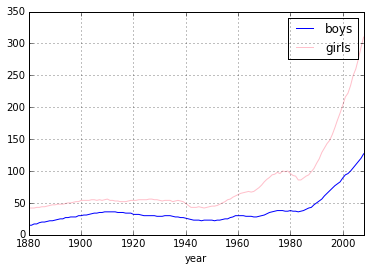

In [58]:
# make it a little util...

def get_quantile_count(group, quantile=0.5):
    return group.sort_index(by="prop", ascending=False).prop.cumsum().searchsorted(quantile)[0]

#for yr in range(1880, 2009):
#    print(yr, get_quantile_count(boys[boys.year == yr]))


# or, simpler...#
#boys.groupby("year").apply(get_quantile_count)
boys.groupby("year").apply(get_quantile_count, 0.5).plot(label="boys")
girls.groupby("year").apply(get_quantile_count, quantile=0.5).plot(color="pink", label="girls")

plt.legend(loc="best")


## Learning about rank()

In [78]:
# let's learn about ranks...

# 1000 names per year; rank them by proportion
#boys[boys.year == 2008].prop

# rank them; if there are ties, they share ranking (e.g. 2.5 at the bottom)
#boys[boys.year == 2008].prop.rank()

#boys.ix[boys[boys.year == 1880].prop.rank().index]
boys.ix[boys[boys.year == 2008].prop.rank().index]

,year,name,prop,sex,soundex
128000,2008,Jacob,0.010355,boy,J210
128001,2008,Michael,0.009437,boy,M240
128002,2008,Ethan,0.009301,boy,E350
128003,2008,Joshua,0.008799,boy,J200
128004,2008,Daniel,0.008702,boy,D540
...,...,...,...,...,...
128995,2008,Kolten,0.000090,boy,K435
128996,2008,Damari,0.000089,boy,D560
128997,2008,Hugh,0.000089,boy,H200
128998,2008,Jensen,0.000089,boy,J525


In [102]:
# select prop field out of groups...
#grouped = boys.groupby("year").prop
#grouped.transform(Series.rank)

#boys["year_ranked"] = grouped.transform(Series.rank)
#idf = boys.set_index("name", "year")
#idf.ix["Juan"].year_ranked.plot()
#idf.ix["Wesley"].year_ranked.plot()

# jds!!!!!!!!!!!!!!!!!  investigate...  !!!!!!!!!!!!!!!!



# Now, explore another dataset: births.csv.
## (we'll be able to perform joins between names & births)

In [103]:
births = read_csv("births.csv")
births


,year,sex,births
0,1880,boy,118405
1,1881,boy,108290
2,1882,boy,122034
3,1883,boy,112487
4,1884,boy,122745
...,...,...,...
255,2005,girl,2024636
256,2006,girl,2084511
257,2007,girl,2109099
258,2008,girl,2072756


In [104]:
# let's do some JOINs, which in pandas is done via merge

# both tables, births and names have 2  common cols:  year and sex

merged = merge(names, births, on=["year", "sex"])

merged

,year,name,prop,sex,soundex,births
0,1880,John,0.081541,boy,J500,118405
1,1880,William,0.080511,boy,W450,118405
2,1880,James,0.050057,boy,J520,118405
3,1880,Charles,0.045167,boy,C642,118405
4,1880,George,0.043292,boy,G620,118405
...,...,...,...,...,...,...
257995,2008,Carleigh,0.000128,girl,C642,2072756
257996,2008,Iyana,0.000128,girl,I500,2072756
257997,2008,Kenley,0.000127,girl,K540,2072756
257998,2008,Sloane,0.000127,girl,S450,2072756


In [105]:

# convert those props into actual numbers...
merged['persons'] = np.floor(merged.prop * merged.births)
merged.head()

,year,name,prop,sex,soundex,births,persons
0,1880,John,0.081541,boy,J500,118405,9654
1,1880,William,0.080511,boy,W450,118405,9532
2,1880,James,0.050057,boy,J520,118405,5926
3,1880,Charles,0.045167,boy,C642,118405,5347
4,1880,George,0.043292,boy,G620,118405,5125


In [106]:
# and we can start plying with things...

merged.groupby(["name", "sex"]).persons.sum()

merged.groupby(["name", "sex"]).persons.sum().order(ascending=False)




name     sex 
James    boy     5021269
John     boy     5016124
Robert   boy     4752198
Michael  boy     4207352
Mary     girl    4097626
                  ...   
Dema     girl          3
Dollye   girl          3
Crissie  girl          3
Daisye   girl          3
Alabama  girl          3
Name: persons, dtype: float64

In [107]:
merged.groupby(["name", "sex"]).persons.sum()



name     sex 
Aaden    boy        959
Aaliyah  girl     39660
Aarav    boy        219
Aaron    boy     508034
         girl      1365
                  ...  
Zola     girl      4847
Zollie   boy         60
Zona     girl      3218
Zora     girl      4551
Zula     girl      3578
Name: persons, dtype: float64

In [108]:


mboys = merge(boys, births, on=["year", "sex"])
mboys["persons"] = np.floor(mboys.prop * mboys.births)
persons = mboys.set_index(["year", "name"]).persons

# it's a Series (w/ a hierarchical index)
persons

year  name   
1880  John       9654
      William    9532
      James      5926
      Charles    5347
      George     5125
                 ... 
2008  Kolten      195
      Damari      193
      Hugh        193
      Jensen      193
      Yurem       193
Name: persons, dtype: float64

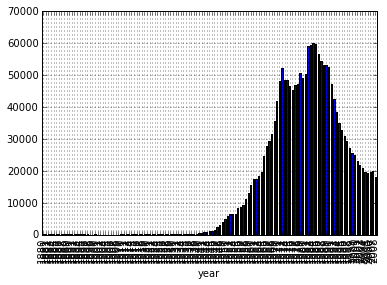

In [109]:

persons.ix[:, "Christopher"]
persons.ix[:, "Christopher"].plot(kind="bar")
persons.ix[:, "Christopher"].plot(kind="bar", rot=90)




In [110]:

# reminder, persons is a Series (w/ a hierarchical index)
# but you can also think of it as a 2D frame
# -> unstack it...
pname = persons.unstack("name")
# or...
# persons.unstack("year")
pname

name,Aaden,Aarav,Aaron,Ab,Abb,Abbie,Abbott,Abdiel,Abdul,Abdullah,...,Zeb,Zebulon,Zechariah,Zed,Zeke,Zenas,Zeno,Zigmund,Zion,Zollie
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,101,4,NaN,NaN,4,NaN,NaN,NaN,...,9,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN
1881,NaN,NaN,93,4,NaN,NaN,NaN,NaN,NaN,NaN,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1882,NaN,NaN,85,5,NaN,NaN,NaN,NaN,NaN,NaN,...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,NaN,NaN,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,NaN,NaN,NaN,5,NaN,5,NaN,NaN,NaN
1884,NaN,NaN,96,NaN,5,NaN,NaN,NaN,NaN,NaN,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,NaN,NaN,8378,NaN,NaN,NaN,NaN,NaN,NaN,191,...,NaN,NaN,307,NaN,NaN,NaN,NaN,NaN,1006,NaN
2005,NaN,NaN,7785,NaN,NaN,NaN,NaN,NaN,NaN,205,...,NaN,NaN,337,NaN,NaN,NaN,NaN,NaN,1114,NaN
2006,NaN,NaN,8272,NaN,NaN,NaN,NaN,NaN,NaN,218,...,NaN,NaN,334,NaN,NaN,NaN,NaN,NaN,1294,NaN


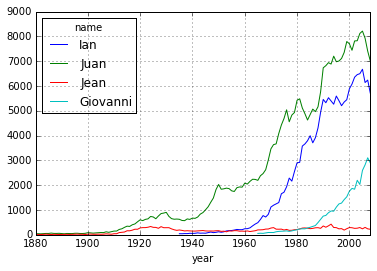

In [118]:
pname[["Ian", "Juan", "Jean", "Giovanni"]].plot()
